# LNG Price Recoupling and Energy Pool

In [302]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

%matplotlib inline

## Net Exporter

In [303]:
imp_exp = pd.read_csv('data/natgas-imports-exports-netimports.csv', skiprows = 6,
                     names = ['Year', 'Imports', 'Exports'])

imp_exp['Net Export'] =  imp_exp['Exports'] - imp_exp['Imports']

imp_exp.head()

,Year,Imports,Exports,Net Export
0,1950,0.00,0.03,0.03
1,1951,0.00,0.02,0.02
2,1952,0.01,0.03,0.02
3,1953,0.01,0.03,0.02
4,1954,0.01,0.03,0.02


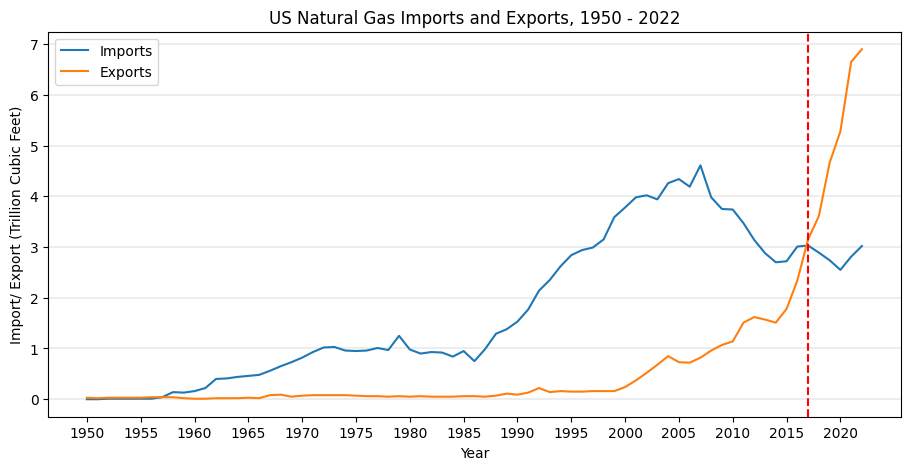

In [304]:
imp_exp.plot('Year', ['Imports', 'Exports'],
             title = 'US Natural Gas Imports and Exports, 1950 - 2022',
             ylabel = 'Import/ Export (Trillion Cubic Feet)',
            figsize = (11,5))
plt.xticks(np.arange(1950, 2022, 5))
plt.grid(axis='y', color='gray', linewidth=0.2)
plt.axvline(x=2017, color='red', linestyle = '--');

In [305]:
#show that US changed to net exporter in 2017
imp_exp[imp_exp["Year"].isin([2016, 2017])][['Year', 'Net Export']]

,Year,Net Export
66,2016,-0.67
67,2017,0.12


<Axes: xlabel='Year'>

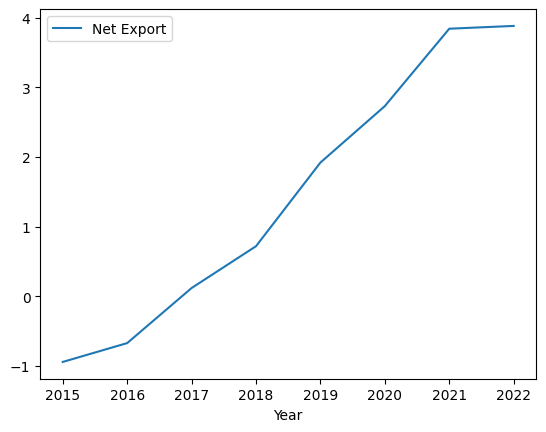

In [306]:
imp_exp[imp_exp["Year"] >= 2015].plot('Year', 'Net Export')

## Prices

In [307]:
#Henry Hub start Jan 1997
henry_hub = pd.read_csv('data/Henry_Hub_Natural_Gas_Spot_Price.csv',
                       skiprows = 5, names = ['Date', 'Henry Hub Price'])

henry_hub['Date'] = pd.to_datetime(henry_hub['Date'], format='%b %Y')

henry_hub.tail()

,Date,Henry Hub Price
328,1997-05-01,2.25
329,1997-04-01,2.03
330,1997-03-01,1.89
331,1997-02-01,2.15
332,1997-01-01,3.45


In [308]:
# Oil WTI prices starting Jan 1986
wti = pd.read_csv('data/Cushing_OK_WTI_Spot_Price_FOB.csv',
                  skiprows = 5, names = ['Date', 'WTI Price'])

wti['Date'] = pd.to_datetime(wti['Date'], format='%b %Y')

wti.tail()

,Date,WTI Price
461,1986-05-01,15.38
462,1986-04-01,12.84
463,1986-03-01,12.61
464,1986-02-01,15.46
465,1986-01-01,22.93


WTI energy parity = 0.172

WTI NGCC parity = 0.127 (-4 for LTR)

(Cite paper)

In [309]:
wti['WTI Energy Parity Price'] = wti['WTI Price'] * 0.172

wti['WTI NGCC Parity Price'] = wti['WTI Price'] * 0.127 - 4

#NGCC Parity only applies after 2016
wti.loc[wti['Date'] < '2016-01-01', 'WTI NGCC Parity Price'] = pd.NA

wti.tail()

,Date,WTI Price,WTI Energy Parity Price,WTI NGCC Parity Price
461,1986-05-01,15.38,2.64536,NaN
462,1986-04-01,12.84,2.20848,NaN
463,1986-03-01,12.61,2.16892,NaN
464,1986-02-01,15.46,2.65912,NaN
465,1986-01-01,22.93,3.94396,NaN


In [310]:
prices = henry_hub.merge(wti, on = "Date", how = "left")

prices.drop('WTI Price', axis = 1, inplace = True)

prices

,Date,Henry Hub Price,WTI Energy Parity Price,WTI NGCC Parity Price
0,2024-09-01,2.28,12.08128,4.92048
1,2024-08-01,1.99,13.18896,5.73836
2,2024-07-01,2.07,14.06960,6.38860
3,2024-06-01,2.54,13.72044,6.13079
4,2024-05-01,2.12,13.76344,6.16254
...,...,...,...,...
328,1997-05-01,2.25,3.58104,NaN
329,1997-04-01,2.03,3.38840,NaN
330,1997-03-01,1.89,3.60684,NaN
331,1997-02-01,2.15,3.81496,NaN


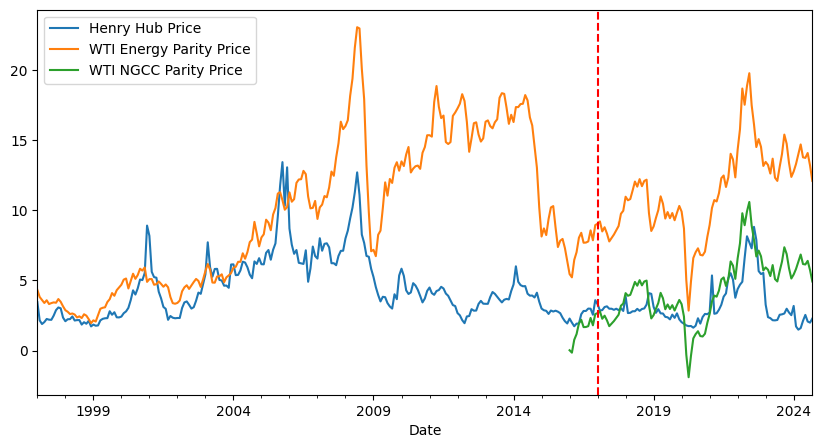

In [311]:
prices.plot('Date', ['Henry Hub Price', 'WTI Energy Parity Price', 'WTI NGCC Parity Price'],
             figsize = (10,5))
plt.axvline(x='2017-01-01', color='red', linestyle = '--')
             

### Yearly Covariance and Correlation Between the Prices

In [312]:
prices['Year'] = prices['Date'].dt.year

yearly_cov = prices.groupby('Year').apply(
    lambda x: pd.Series({
        'Energy Parity Covariance': x['Henry Hub Price'].cov(x['WTI Energy Parity Price']),
        'NGCC Parity Covariance': x['Henry Hub Price'].cov(x['WTI NGCC Parity Price']),
        'Energy Parity Correlation': x['Henry Hub Price'].corr(x['WTI Energy Parity Price']),
        'NGCC Parity Correlation': x['Henry Hub Price'].corr(x['WTI NGCC Parity Price'])
    })
    )

yearly_cov = yearly_cov.reset_index()

yearly_cov.tail()

/var/folders/pb/cpqxrzd16p329rb899j1pskw0000gn/T/ipykernel_2080/269641353.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  yearly_cov = prices.groupby('Year').apply(


,Year,Energy Parity Covariance,NGCC Parity Covariance,Energy Parity Correlation,NGCC Parity Correlation
23,2020,0.259938,0.191931,0.405409,0.405409
24,2021,0.938528,0.692983,0.581716,0.581716
25,2022,1.255396,0.926949,0.394568,0.394568
26,2023,0.168485,0.124404,0.498739,0.498739
27,2024,-0.218023,-0.160982,-0.541530,-0.541530


Text(0.5, 1.0, 'Yearly Covariance between Henry Hub and WTI Prices')

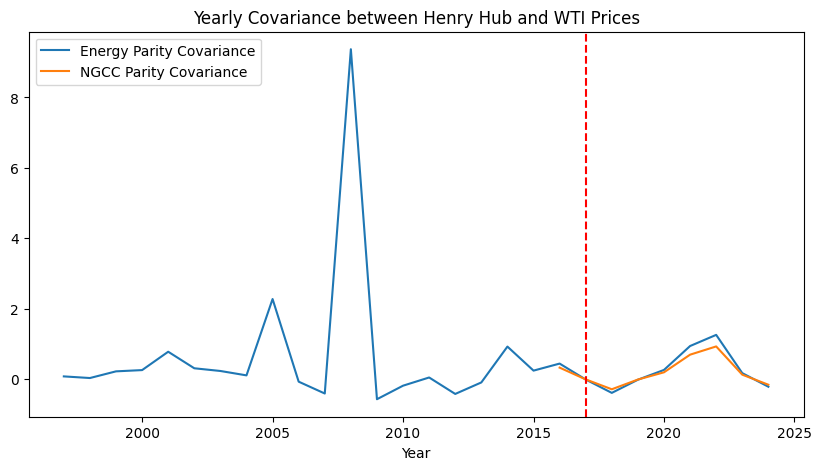

In [313]:
yearly_cov.plot('Year', 
            ['Energy Parity Covariance', 'NGCC Parity Covariance'],
             figsize = (10,5))
plt.axvline(x= 2017, color='red', linestyle = '--')
plt.title('Yearly Covariance between Henry Hub and WTI Prices')


Text(0.5, 1.0, 'Yearly Correlation between Henry Hub and WTI Prices')

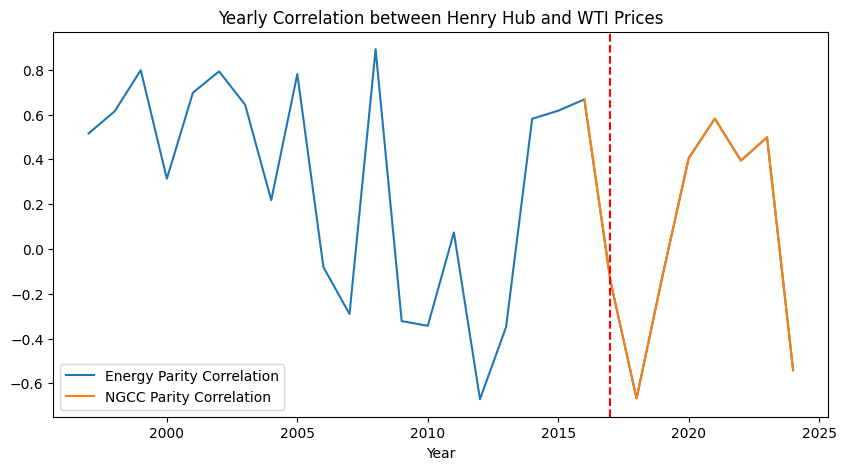

In [314]:
yearly_cov.plot('Year', 
            ['Energy Parity Correlation', 'NGCC Parity Correlation'],
             figsize = (10,5))
plt.axvline(x= 2017, color='red', linestyle = '--')
plt.title('Yearly Correlation between Henry Hub and WTI Prices')

### Difference of Marginal Change of Prices

In [315]:
prices['Henry Hub Marginal Change'] = prices['Henry Hub Price'].diff()
prices['WTI Energy Parity Marginal Change'] = prices['WTI Energy Parity Price'].diff()
prices['WTI NGCC Parity Marginal Change'] = prices['WTI NGCC Parity Price'].diff()

prices.head()

,Date,Henry Hub Price,WTI Energy Parity Price,WTI NGCC Parity Price,Year,Henry Hub Marginal Change,WTI Energy Parity Marginal Change,WTI NGCC Parity Marginal Change
0,2024-09-01,2.28,12.08128,4.92048,2024,NaN,NaN,NaN
1,2024-08-01,1.99,13.18896,5.73836,2024,-0.29,1.10768,0.81788
2,2024-07-01,2.07,14.06960,6.38860,2024,0.08,0.88064,0.65024
3,2024-06-01,2.54,13.72044,6.13079,2024,0.47,-0.34916,-0.25781
4,2024-05-01,2.12,13.76344,6.16254,2024,-0.42,0.04300,0.03175


<Axes: xlabel='Date'>

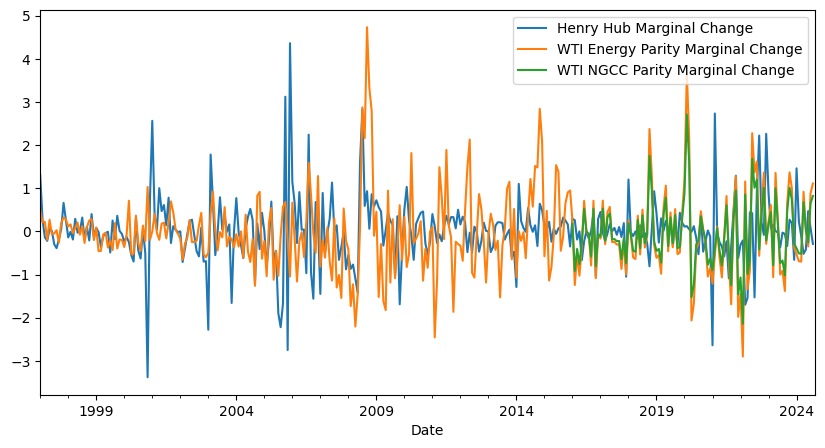

In [316]:
prices.plot('Date', 
            ['Henry Hub Marginal Change', 'WTI Energy Parity Marginal Change', 'WTI NGCC Parity Marginal Change'],
             figsize = (10,5))

In [317]:
prices['Energy Parity Difference'] = abs(prices['WTI Energy Parity Marginal Change'] - prices['Henry Hub Marginal Change'])
prices['NGCC Parity Difference'] = abs(prices['WTI NGCC Parity Marginal Change'] - prices['Henry Hub Marginal Change'])

prices.loc[prices['Date'] < '2016-01-01', 'WTI NGCC Parity Marginal Change'] = pd.NA
prices.loc[prices['Date'] < '2016-01-01', 'NGCC Parity Difference'] = pd.NA

prices.tail()

,Date,Henry Hub Price,WTI Energy Parity Price,WTI NGCC Parity Price,Year,Henry Hub Marginal Change,WTI Energy Parity Marginal Change,WTI NGCC Parity Marginal Change,Energy Parity Difference,NGCC Parity Difference
328,1997-05-01,2.25,3.58104,NaN,1997,0.05,0.26832,NaN,0.21832,NaN
329,1997-04-01,2.03,3.38840,NaN,1997,-0.22,-0.19264,NaN,0.02736,NaN
330,1997-03-01,1.89,3.60684,NaN,1997,-0.14,0.21844,NaN,0.35844,NaN
331,1997-02-01,2.15,3.81496,NaN,1997,0.26,0.20812,NaN,0.05188,NaN
332,1997-01-01,3.45,4.32236,NaN,1997,1.30,0.50740,NaN,0.79260,NaN


<Axes: xlabel='Date'>

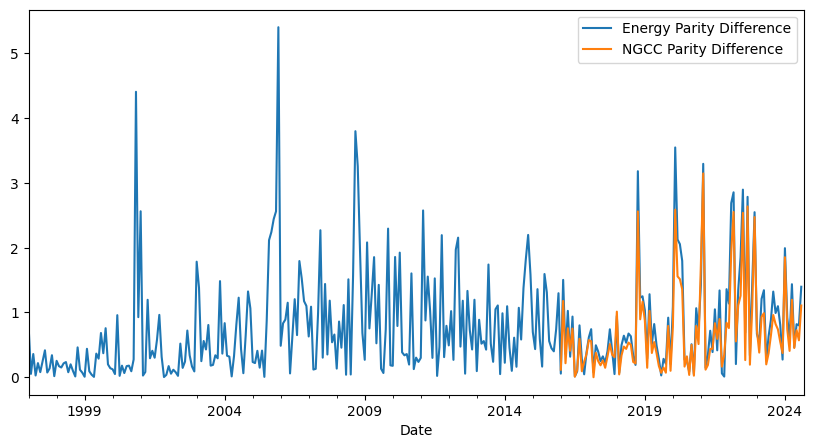

In [318]:
prices.plot('Date', 
            ['Energy Parity Difference', 'NGCC Parity Difference'],
             figsize = (10,5))

## Extraction/ Production by State

https://www.eia.gov/dnav/ng/ng_prod_sum_a_EPG0_FGW_mmcf_m.htm

In [319]:
extract = pd.read_csv('data/US Natural Gas Extraction by State.csv')

extract['Date'] = pd.to_datetime(extract['Date'], format='%b-%Y')
extract.set_index('Date', inplace = True)
extract.drop(columns = 'Gulf of Mexico', inplace = True)

extract.head()

,Alaska,Arkansas,California,Colorado,Kansas,Louisiana,Montana,New Mexico,North Dakota,Ohio,Oklahoma,Pennsylvania,Texas,Utah,West Virginia,Wyoming,US Total
Date,,,,,,,,,,,,,,,,,
1991-01-01,206213,19595,36651,21103,64057,475615,5317,98168,5413,13138,194179,13538,613705,29169,17794,81224,1956947
1991-02-01,192757,16126,32831,24172,54742,415395,4533,81480,4886,11794,176577,12153,540324,25803,15880,72419,1737959
1991-03-01,212592,16675,39214,24435,58012,446189,4861,90924,5408,12855,189362,13271,578880,28696,17289,87728,1889228
1991-04-01,193357,13393,37554,25590,52088,427529,4866,87912,5186,12191,182592,12588,556087,27430,16401,83390,1799742
1991-05-01,189547,13191,37761,23263,50888,421558,4600,87739,5231,12085,181866,12483,561205,26066,16256,79090,1786338


In [320]:
extract.tail()

,Alaska,Arkansas,California,Colorado,Kansas,Louisiana,Montana,New Mexico,North Dakota,Ohio,Oklahoma,Pennsylvania,Texas,Utah,West Virginia,Wyoming,US Total
Date,,,,,,,,,,,,,,,,,
2024-04-01,293233,30219,10143,152885,10076,301412,3848,285795,104422,180272,228427,583413,1040348,25002,276228,100388,3716254
2024-05-01,298199,31054,10516,156211,10604,294644,3948,297788,108797,190090,239125,602978,1093986,25855,280999,103085,3834338
2024-06-01,270590,29676,10257,148915,10190,283356,3861,292554,104583,177260,230102,611021,1067303,24977,277988,101278,3731414
2024-07-01,275385,30531,10546,154689,10521,307675,3982,308576,106943,179158,235450,649870,1104900,25852,293427,103797,3892232
2024-08-01,262261,30438,10387,155184,10464,301207,4070,314996,109338,178414,231222,621077,1118164,25330,289951,101874,3855874


In [321]:
states = extract.drop(columns = ['US Total']).columns.tolist()

states

['Alaska',
 'Arkansas',
 'California',
 'Colorado',
 'Kansas',
 'Louisiana',
 'Montana',
 'New Mexico',
 'North Dakota',
 'Ohio',
 'Oklahoma',
 'Pennsylvania',
 'Texas',
 'Utah',
 'West Virginia',
 'Wyoming']

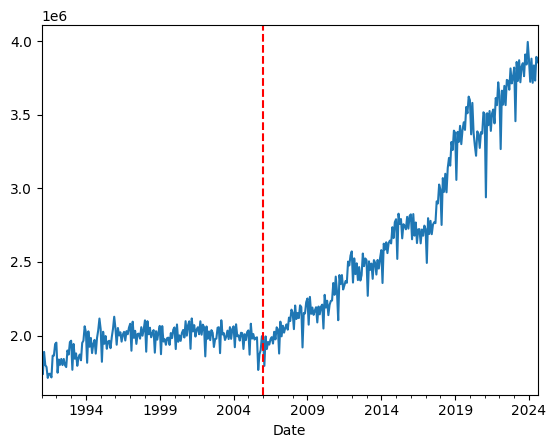

In [322]:
extract['US Total'].plot()
plt.axvline(x='2006-01-01', color='red', linestyle = '--')

<Axes: xlabel='Date'>

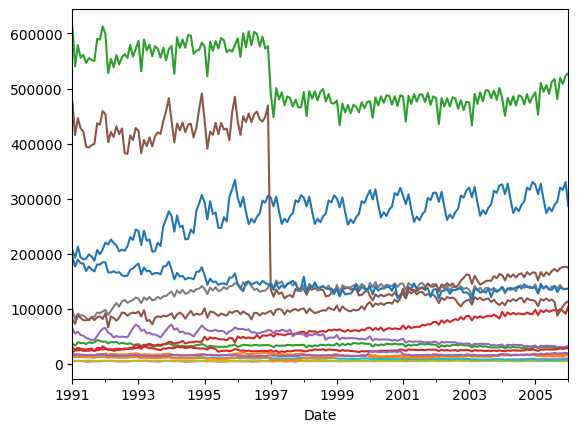

In [323]:
# Steep drop in 1997, so take the data from there
extract[extract.index <= '2006-01-01'].drop(columns = ['US Total']).plot(legend = False)

In [324]:
extract = extract[extract.index >= '1997-01-01'].drop(columns = ['US Total'])

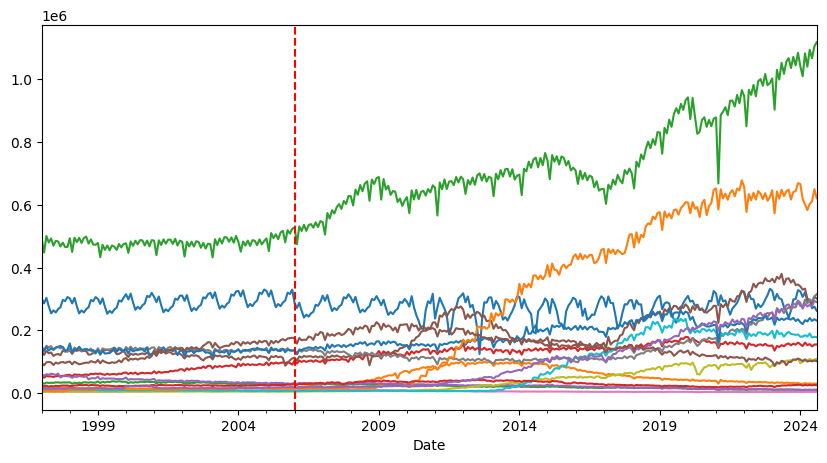

In [325]:
extract.plot(legend = False, figsize = (10, 5))
plt.axvline(x='2006-01-01', color='red', linestyle = '--')

In [326]:
pre_fracking = extract[extract.index < '2006-01-01']
post_fracking = extract[extract.index >= '2006-01-01']

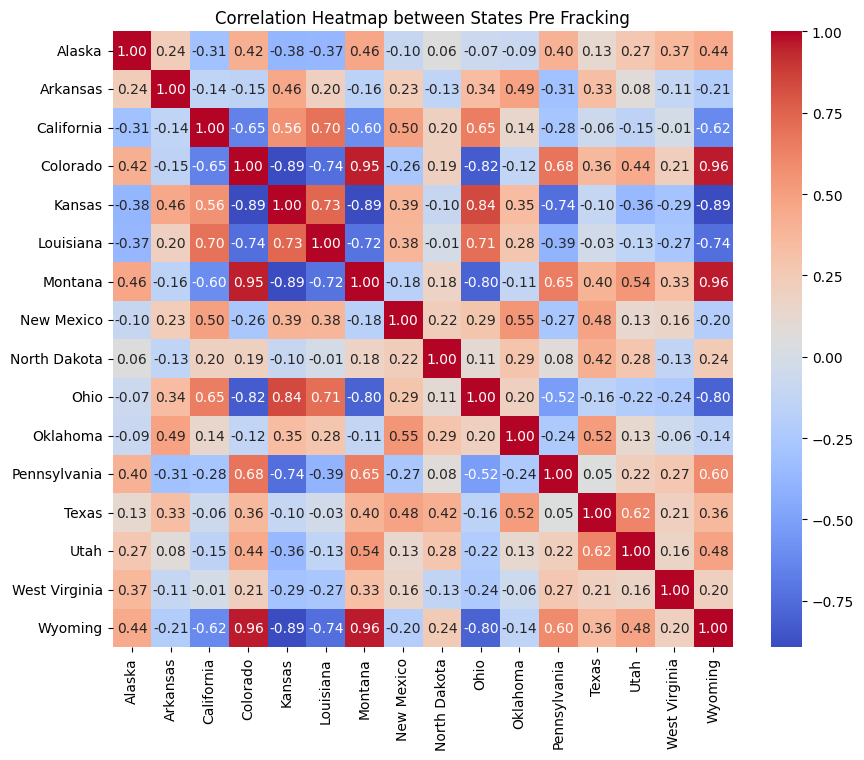

In [327]:
corr_matrix = pre_fracking.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap between States Pre Fracking')
plt.show()

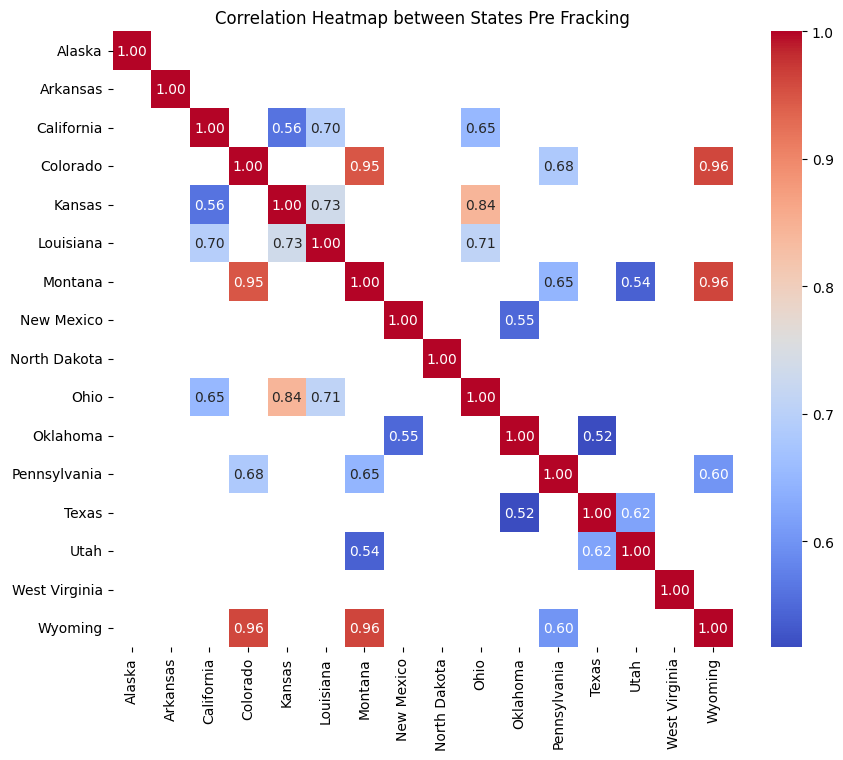

In [340]:
corr_mid = corr_matrix[(corr_matrix >= 0.5)]

plt.figure(figsize=(10, 8))
sns.heatmap(corr_mid, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap between States Pre Fracking')
plt.show()

<Axes: xlabel='Date'>

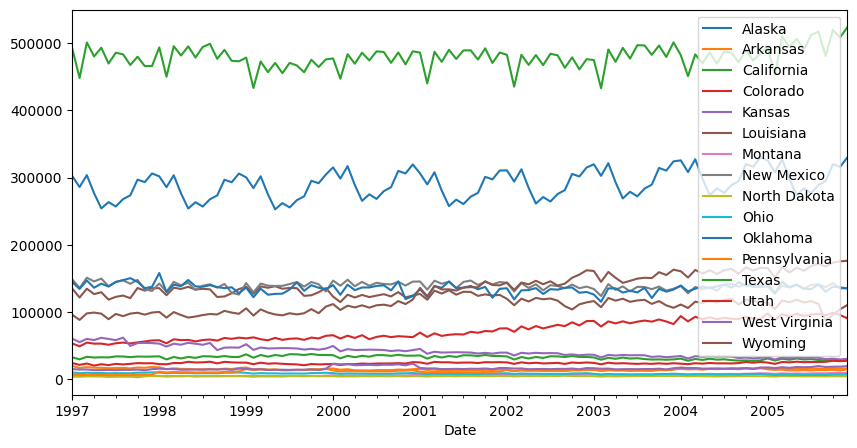

In [329]:
select_states = ['North Dakota', 'Ohio', 'Oklahoma', 'Pennsylvania', 'Texas', 'West Virginia']
select_states_pre = ['Colorado', 'Louisiana', 'Montana']

pre_fracking.plot(figsize = (10, 5))

In [330]:
mean_diff = post_fracking.mean() - pre_fracking.mean()
mean_diff.sort_values(ascending = False)

Pennsylvania     326909.628472
Texas            269329.470403
West Virginia     98590.994378
Louisiana         90543.156911
Ohio              86087.013724
Colorado          66879.273810
Oklahoma          58156.083664
North Dakota      42630.414352
Arkansas          41660.135582
Wyoming           29157.785549
Utah               6388.939980
New Mexico         4964.470899
Montana            -828.695602
California       -13173.345403
Alaska           -14862.927745
Kansas           -20360.667659
dtype: float64

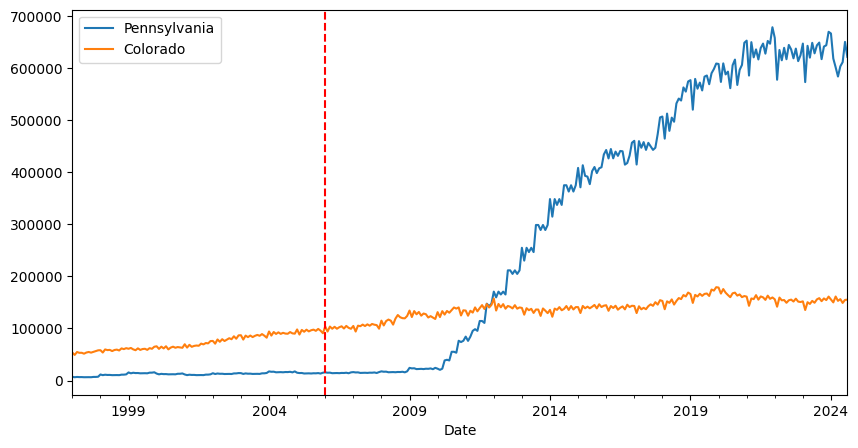

In [331]:
extract[['Pennsylvania', 'Colorado']].plot(figsize = (10, 5))
plt.axvline(x='2006-01-01', color='red', linestyle = '--')

## Emission

https://www.eia.gov/environment/emissions/state/

In [332]:
emission = pd.read_csv('data/US Energy-Related CO2 State Emission.csv', skiprows = 4)

emission.set_index('State', inplace = True)
emission = emission.transpose().iloc[:-4]
emission.index = emission.index.astype(int)
emission = emission.loc[emission.index >= 1997, states].astype(float)

emission.head()

State,Alaska,Arkansas,California,Colorado,Kansas,Louisiana,Montana,New Mexico,North Dakota,Ohio,Oklahoma,Pennsylvania,Texas,Utah,West Virginia,Wyoming
1997,41.2,59.1,352.3,75.8,71.2,221.1,29.9,55.8,47.3,261.2,98.5,276.8,649.1,61.1,111.1,59.0
1998,42.2,60.5,362.2,78.1,70.1,207.7,32.0,55.4,48.5,260.4,97.0,266.1,655.4,63.5,115.3,63.9
1999,42.8,62.7,365.6,80.2,73.2,205.9,32.8,56.3,49.6,259.6,96.1,264.7,645.8,62.4,116.4,62.5
2000,43.6,63.3,382.0,85.3,75.8,220.4,31.7,58.2,51.0,266.6,100.1,278.4,672.5,65.4,115.7,63.5
2001,42.5,62.5,385.3,93.0,71.8,198.5,32.0,58.4,51.7,256.7,101.4,264.9,666.3,63.2,105.6,63.7


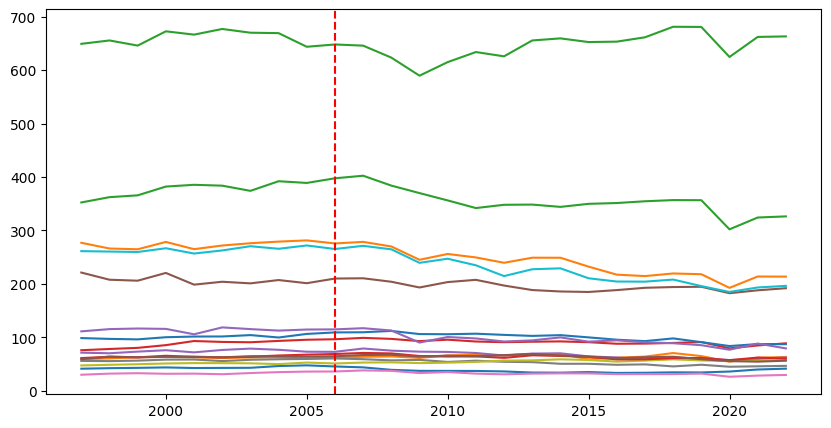

In [333]:
emission.plot(legend = False, figsize = (10, 5))
plt.axvline(x = 2006, color='red', linestyle = '--')

In [335]:
pre_emission = emission[emission.index < 2006]
post_emission = emission[emission.index >= 2006]

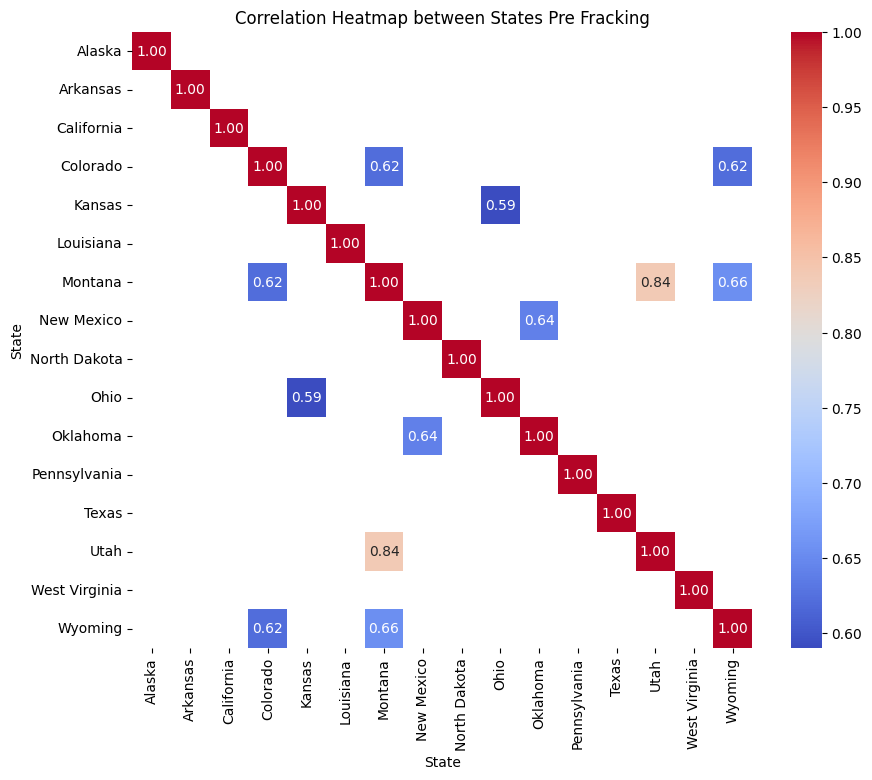

In [339]:
emm_corr = pre_emission.corr()

emm_corr_high = emm_corr[emm_corr >= 0.5][corr_matrix >= 0.5]

plt.figure(figsize=(10, 8))
sns.heatmap(emm_corr_high, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap between States Pre Fracking')
plt.show()

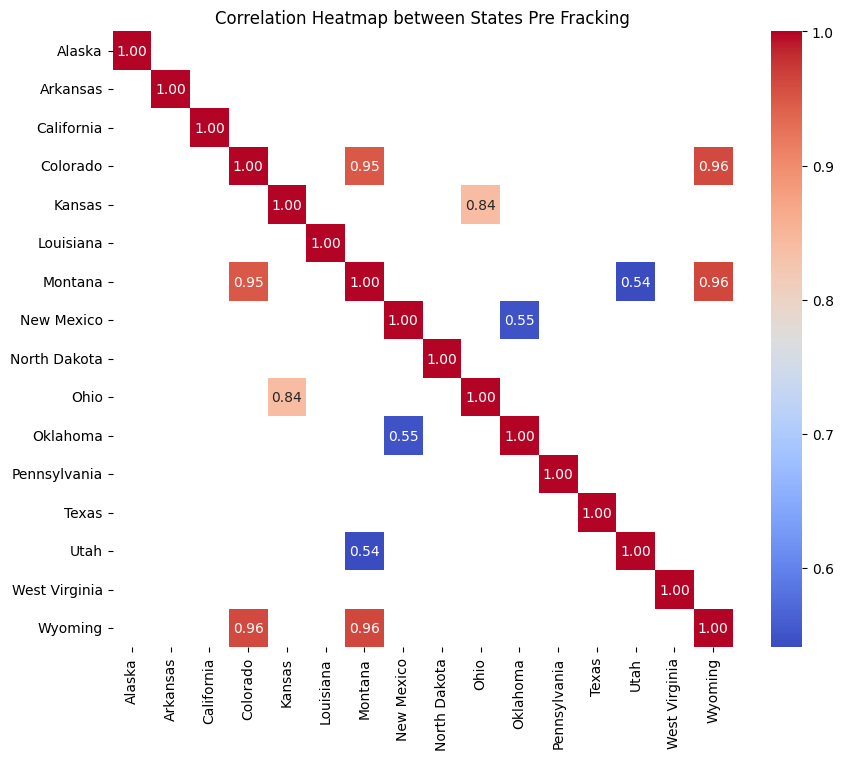

In [341]:
mat_corr_high = corr_matrix[emm_corr >= 0.5][corr_matrix >= 0.5]

plt.figure(figsize=(10, 8))
sns.heatmap(mat_corr_high, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title('Correlation Heatmap between States Pre Fracking')
plt.show()

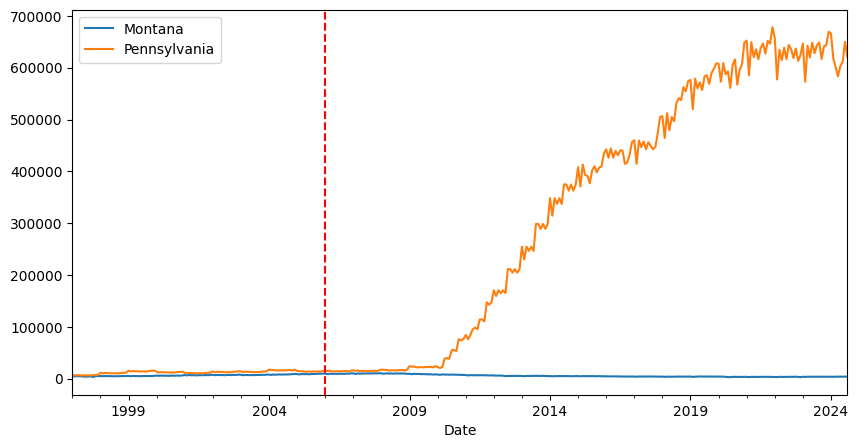

In [349]:
extract[['Montana', 'Pennsylvania']].plot(figsize = (10, 5))
plt.axvline(x = '2006-01-01', color='red', linestyle = '--')

<Axes: >

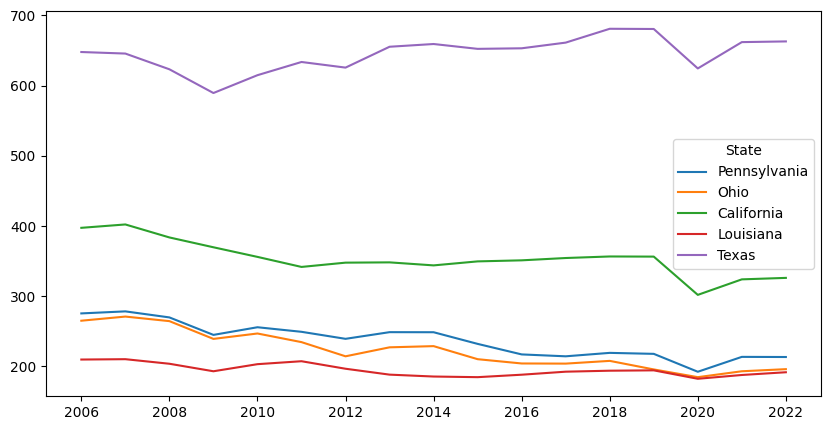

In [357]:
post_emission[['Pennsylvania', 'Ohio', 'California', 'Louisiana', 'Texas']].plot(legend = True, figsize = (10, 5))

<Axes: xlabel='Date'>

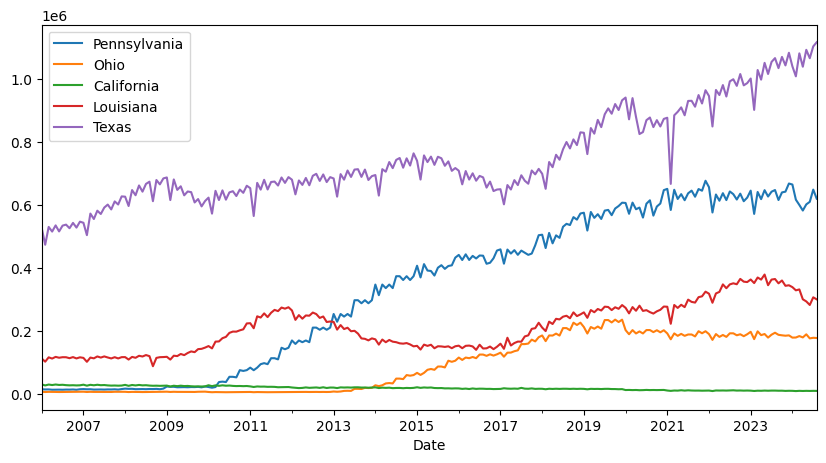

In [358]:
post_fracking[['Pennsylvania', 'Ohio', 'California', 'Louisiana', 'Texas']].plot(legend = True, figsize = (10, 5))

In [354]:
emission.mean().sort_values(ascending = False)

State
Texas            650.850000
California       361.473077
Pennsylvania     249.665385
Ohio             237.088462
Louisiana        199.315385
West Virginia    101.492308
Oklahoma          99.976923
Colorado          89.634615
Kansas            69.311538
Utah              63.565385
Arkansas          63.100000
Wyoming           62.976923
New Mexico        53.742308
North Dakota      53.561538
Alaska            39.319231
Montana           32.346154
dtype: float64